# Relevant imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date as dt

import folium
from folium import plugins
from folium.plugins import HeatMap
#http://geopandas.org/install.html
import geopandas as gpd

import plotnine
from plotnine import * 
from IPython.display import display
import warnings 
warnings.filterwarnings("ignore")
import math

ModuleNotFoundError: No module named 'plotnine'

In [ ]:
inspections = pd.read_pickle('./datasets/cleaned_inspections.pickle')

In [ ]:
inspections.head(2)

# Exploratory data analysis

- Let's look at the inspections over the date of inspections in Chicago city.

In [4]:
inspections['Inspection Year'] =  [x.year for x in inspections['Inspection Date']]
inspections['Inspection Month'] =  [x.month for x in inspections['Inspection Date']]
group_by_inspection_date = inspections.groupby(by=['Inspection Year', 'Inspection Month']).size().reset_index(name="Count")
group_by_inspection_date = group_by_inspection_date.sort_values(by=['Inspection Year', 'Inspection Month'], ascending = True)
group_by_inspection_date = group_by_inspection_date.set_index(['Inspection Year', 'Inspection Month'])
group_by_inspection_date

Count
Inspection Year Inspection Month       
2010            1                  1224
                2                  1368
                3                  1414
                4                  1387
                5                  1457
...                                 ...
2019            7                  1344
                8                  1445
                9                  1190
                10                 1260
                11                  130

[119 rows x 1 columns]

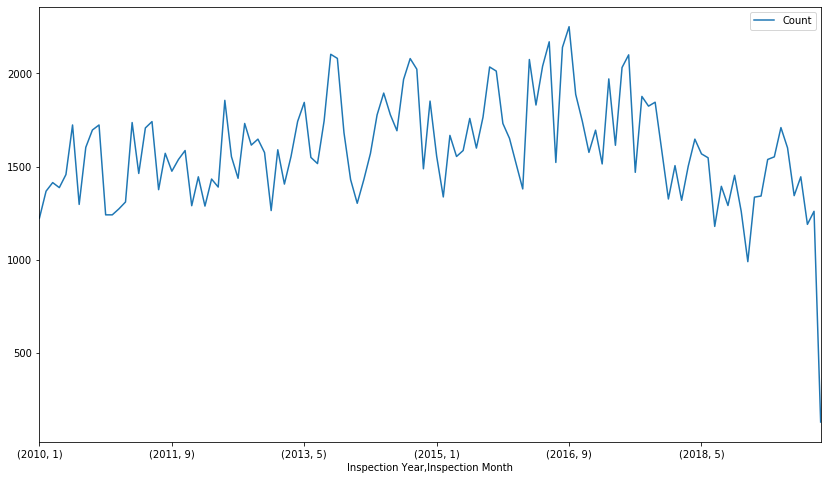

In [5]:
group_by_inspection_date.plot(kind="line", figsize = (14,8))
plt.show()

Here we see that our inspections counts based on inspection year, month, we have similar result shown [here](https://data.cityofchicago.org/Health-Human-Services/Food-Inspections-Dashboard/2bnm-jnvb). Hence, even after our data cleaning we are on a good track since we didn't lose the big picture of our dataset. 

- Let's look at the locations of each facility type in the Chicago Food Inspection dataset by ploting the latitude and longitude: 

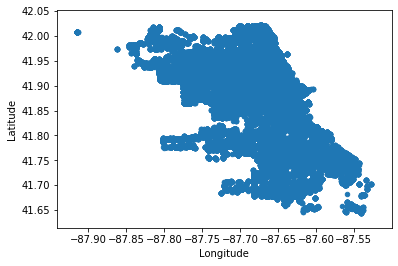

In [6]:
inspections.plot.scatter(x = 'Longitude', y ='Latitude')
plt.rcParams["figure.figsize"] = (12,8)
plt.show()

We can see from the above scatter plot that it looks like the Chicago map that we came across on the internet.

- Let's look at facility types in terms of how frequently they are inspected. We see this information from the 'Risk" fields in our data: For that, we only looked at the Facility Types where their risk is 'High', which is '1'.

In [7]:
group_by_facilitytype_risk = inspections.groupby(by=['Facility Type', 'Risk']).size().reset_index(name="Count")
group_by_facilitytype_High_risk = group_by_facilitytype_risk[group_by_facilitytype_risk['Risk']==1].sort_values(by='Count', ascending= False)
group_by_facilitytype_High_risk['Percentage'] = 100*(group_by_facilitytype_High_risk['Count']/sum(group_by_facilitytype_High_risk['Count']))
group_by_facilitytype_High_risk = group_by_facilitytype_High_risk.sort_values(by='Percentage', ascending = False)
group_by_facilitytype_High_risk = group_by_facilitytype_High_risk.reset_index(inplace = False)
group_by_facilitytype_High_risk = group_by_facilitytype_High_risk.drop(columns="index")
group_by_facilitytype_High_risk


,Facility Type,Risk,Count,Percentage
0,Restaurant,1,102893,75.834494
1,Educational Establishment,1,19333,14.248863
2,Market,1,7406,5.458391
3,Other,1,1694,1.248517
4,Retirement Homes,1,1440,1.061313
5,Catering Establishment,1,1130,0.832836
6,Bakery,1,1085,0.799670
7,Shared Kitchens,1,249,0.183519
8,Kiosk,1,179,0.131927
9,Shelters,1,89,0.065595


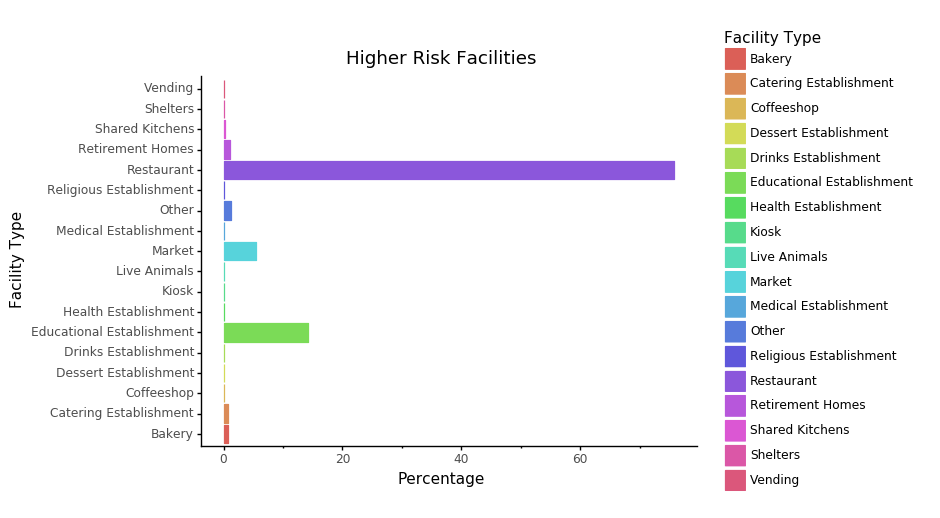

<ggplot: (284637353)>

In [8]:
#Plotting Facilities that alerts higher riskiness
higher_risk_facilities = ggplot(group_by_facilitytype_High_risk, aes(x='Facility Type', y='Percentage', 
                                                                     fill='Facility Type', color = 'Facility Type'))\
                        + geom_col() + coord_flip() \
                        + theme_classic() + ggtitle('Higher Risk Facilities')


display(higher_risk_facilities)

- Let's look at the inspection results:

In [9]:
group_by_result = inspections.groupby(by=['Results']).size().reset_index(name="Count")
group_by_result = group_by_result.sort_values(by='Count', ascending = False)
group_by_result = group_by_result.set_index('Results')
group_by_result

,Count
Results,
Pass,101959
Fail,36737
Pass w/ Conditions,26177
Out of Business,16294
No Entry,6038
Not Ready,1817
Business Not Located,64


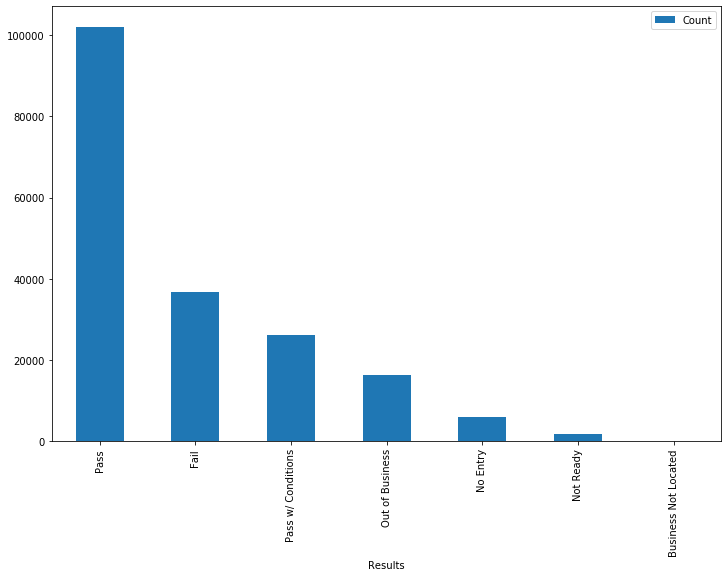

In [10]:
group_by_result.plot(kind="bar")
plt.rcParams["figure.figsize"] = (16,8)
plt.show()

- Let's now only keep the 'Pass', 'Fail' and 'Pass w/ Conditions' results.

In [11]:
group_by_result_only3 = group_by_result[:3]

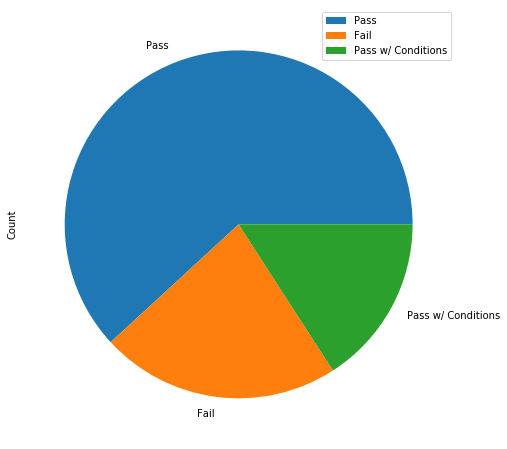

In [12]:
group_by_result_only3.plot(kind="pie", y='Count')
plt.rcParams["figure.figsize"] = (16,8)
plt.show()

We see that among the three results, 'Pass' results seem to have more common result than 'Fail' and 'Pass w/ Conditions'.

- Let's now look at the inspection results for each different facility type.

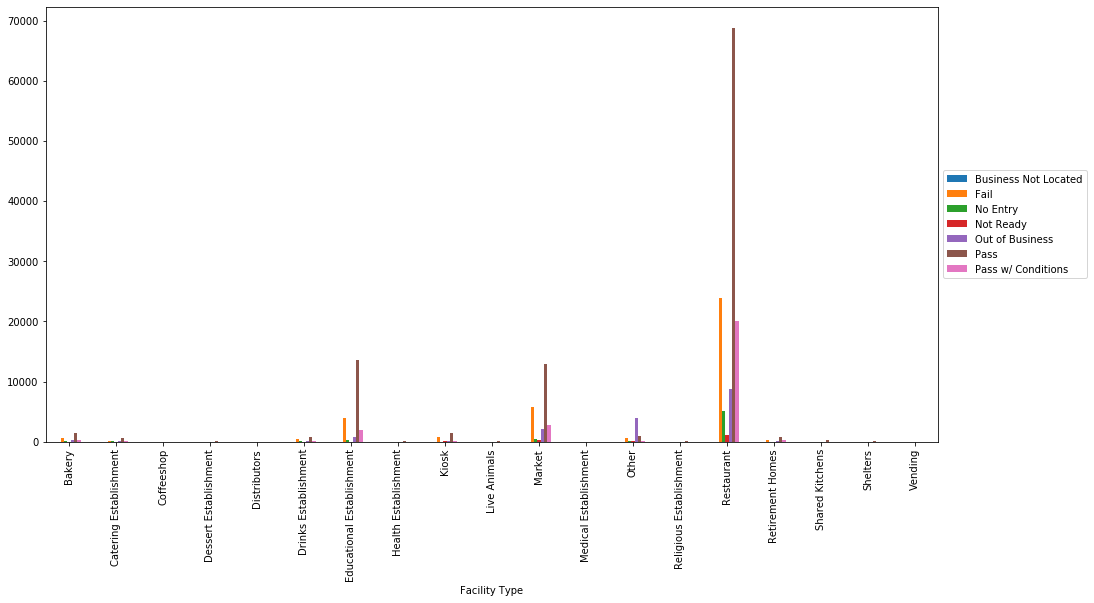

In [13]:
group_by_facilitytype_result = inspections.groupby(by=['Facility Type', 'Results']).size().reset_index(name="Count")
df = pd.pivot_table(group_by_facilitytype_result,  values='Count',  columns=['Results'],  
                    index = "Facility Type", aggfunc=np.sum, fill_value=0)
df.plot(kind="bar")
plt.rcParams["figure.figsize"] = (16,8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

To see the scale of facility types better we examine by doing a log scaling on y axis.

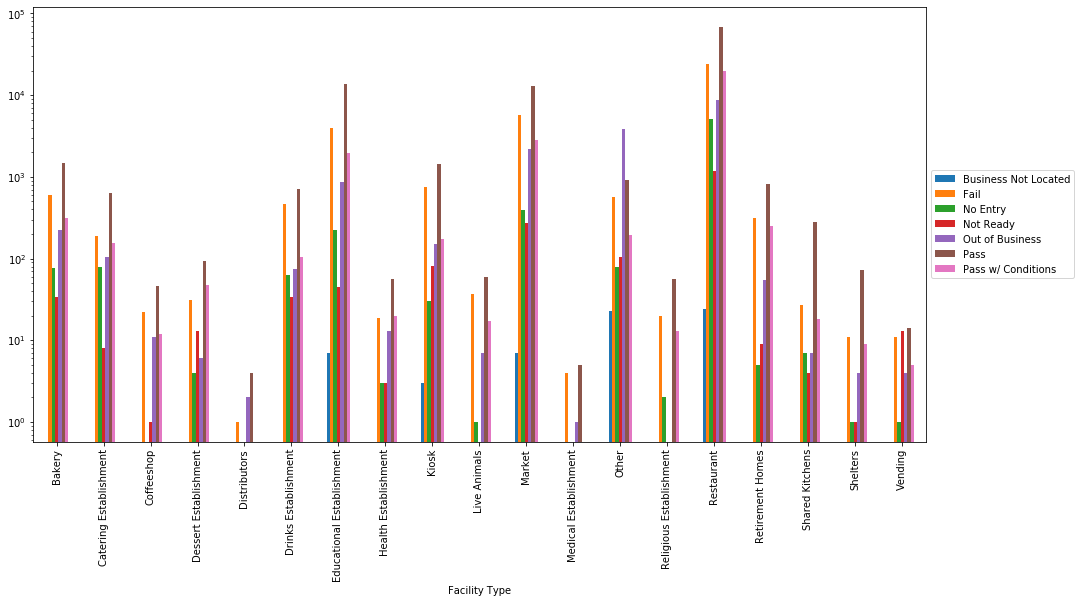

In [14]:
group_by_facilitytype_result = inspections.groupby(by=['Facility Type', 'Results']).size().reset_index(name="Count")
df = pd.pivot_table(group_by_facilitytype_result,  values='Count',  columns=['Results'],  
                    index = "Facility Type", aggfunc=np.sum, fill_value=0)
df.plot(kind="bar", logy=True) 
plt.rcParams["figure.figsize"] = (16,8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

- Let's look at how spread out the frequency of an inspection occurs over the locations of the facilities in Chicago.

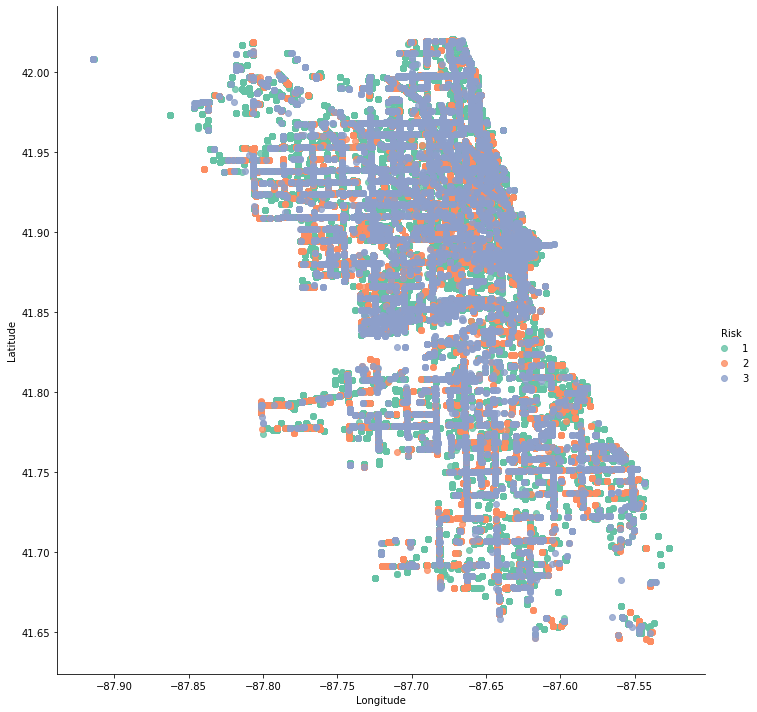

In [15]:
sns.lmplot(x = 'Longitude', y ='Latitude', 
           data = inspections, 
           hue = "Risk", 
           height = 10,
           palette="Set2", fit_reg = False)

- Let's look at violation numbers in our data.

In [16]:
#Let's filter out the NaN value rows in our Violation Numbers column. 
inspections_with_filtered_violations = inspections[~pd.isnull(inspections['Violation Numbers'])]

In [17]:
inspections_with_filtered_violations = inspections_with_filtered_violations.reset_index()

In [19]:
inspections_with_filtered_violations = inspections_with_filtered_violations.drop(columns='index')

In [20]:
inspections_with_filtered_violations['Violation Counts'] = [len(inspections_with_filtered_violations['Violation Numbers'][i]) for i in range(len(inspections_with_filtered_violations))]


In [21]:
inspections_with_filtered_violations

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Community Area,Violation Numbers,Violation Comments,Inspection Year,Inspection Month,Violation Counts
0,2345318,SUBWAY,SUBWAY,2529116,Restaurant,1,2620 N NARRAGANSETT AVE,2019-11-08,Canvass Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.927995,-87.785752,"41.92799528871574, -87.78575236468352",Belmont Cragin,"[3, 5, 58]",[ 2-102.14(O) OBSERVED NO WRITTEN EMPLOYEE HE...,2019,11,3
1,2321166,SUBWAY,SUBWAY,2529116,Restaurant,1,2620 N NARRAGANSETT AVE,2019-11-06,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.927995,-87.785752,"41.92799528871574, -87.78575236468352",Belmont Cragin,"[3, 5, 10, 22, 33, 57, 58]",[ OBSERVED NO WRITTEN EMPLOYEE HEALTH POLICY O...,2019,11,7
2,2290717,PAPA JOHN'S PIZZA,PAPA JOHN'S PIZZA,1545897,Restaurant,2,2620 N NARRAGANSETT AVE,2019-05-30,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.927995,-87.785752,"41.92799528871574, -87.78575236468352",Belmont Cragin,"[3, 5]",[ OBSERVED NO EMPLOYEE HEALTH POLICY ON THE PR...,2019,5,2
3,2144588,SUBWAY,SUBWAY,2529116,Restaurant,1,2620 N NARRAGANSETT AVE,2018-02-06,Canvass,Fail,"16. FOOD PROTECTED DURING STORAGE, PREPARATION...",41.927995,-87.785752,"41.92799528871574, -87.78575236468352",Belmont Cragin,"[16, 34, 42]",[ OBSERVED BLACK AND PINK MOLD LIKE SUBSTANCES...,2018,2,3
4,2064444,PAPA JOHN'S PIZZA,PAPA JOHN'S PIZZA,1545897,Restaurant,2,2620 N NARRAGANSETT AVE,2017-06-16,Canvass Re-Inspection,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.927995,-87.785752,"41.92799528871574, -87.78575236468352",Belmont Cragin,"[32, 33, 34, 35, 37, 43, 45]","[ Inspector Comments, Inspector Comments, ...",2017,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134260,1375799,AWONE,AWONE,1447897,Other,3,4710 N KEDZIE AVE,2013-12-03,Canvass,Out of Business,NaN,41.967002,-87.708575,"41.967001638307664, -87.70857453355956",Albany Park,"[32, 34]",[ All food and non-food contact equipment and ...,2013,12,2
134261,1375797,AWONE,AWONE,1479698,Other,3,4710 N KEDZIE AVE,2013-11-26,Canvass,Out of Business,NaN,41.967002,-87.708575,"41.967001638307664, -87.70857453355956",Albany Park,"[12, 18, 32]","[ WITH SOAP AND SANITARY HAND DRYING DEVICES, ...",2013,11,3
134262,251051,LAS TRES CAMPANITAS #2,LAS TRES CAMPANITAS #2,2033134,Restaurant,2,3510 W 26th ST,2010-06-17,License Re-Inspection,Pass,NaN,41.844516,-87.712868,"41.84451594024355, -87.71286845086306",South Lawndale,"[33, 34, 35, 38, 41]",[ All food and non-food contact surfaces of eq...,2010,6,5
134263,63371,LAS TRES CAMPANITAS #2,LAS TRES CAMPANITAS #2,2033134,Restaurant,2,3510 W 26th ST,2010-06-01,License,Fail,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.844516,-87.712868,"41.84451594024355, -87.71286845086306",South Lawndale,"[33, 34, 35, 38, 41]",[ All food and non-food contact surfaces of eq...,2010,6,5


In [28]:
group_by_FacilityType_violation = inspections_with_filtered_violations\
                                                    .groupby(by=['Facility Type'])\
                                                    .sum()

group_by_FacilityType_violation

,Inspection ID,License #,Risk,Latitude,Longitude,Inspection Year,Inspection Month,Violation Counts
Facility Type,,,,,,,,
Bakery,2933633336,3168285062,3168,8.293291e+04,-1.735582e+05,3986824,13827,8735
Catering Establishment,1234735703,1416828686,872,3.455798e+04,-7.233257e+04,1662110,5606,3657
Coffeeshop,76231385,89307527,114,2.261574e+03,-4.733155e+03,108772,434,244
Dessert Establishment,202331541,302841285,337,5.739680e+03,-1.201334e+04,276013,768,652
Distributors,10986924,14787090,16,2.512275e+02,-5.259298e+02,12100,28,32
Drinks Establishment,1220737699,1348238166,2098,3.276497e+04,-6.855906e+04,1575742,5284,3372
Educational Establishment,21655729511,20734738898,16322,6.337381e+05,-1.327662e+06,30505286,90719,66884
Health Establishment,117933256,144517707,166,3.180842e+03,-6.661270e+03,153132,601,370
Kiosk,2252718515,3140173603,3864,6.681345e+04,-1.399182e+05,3214813,10479,7280


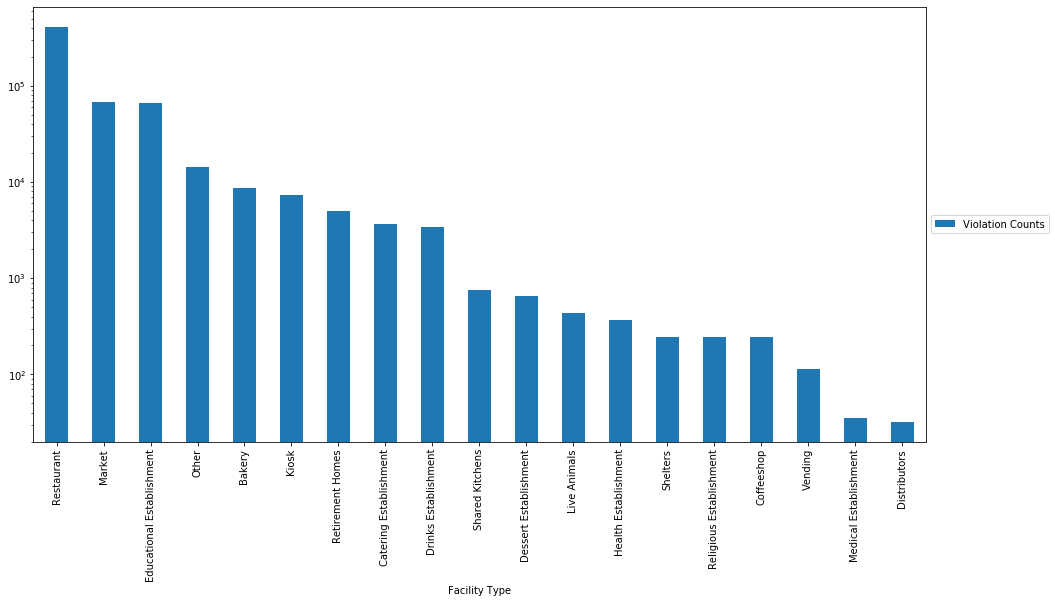

In [32]:
group_by_FacilityType_violation['Violation Counts'].sort_values(ascending = False).plot(kind="bar", logy = True) 
plt.rcParams["figure.figsize"] = (16,8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Data Visualization using folium

## 1. Restaurants on a map

Let's display on a map the different restaurants in our dataset

In [4]:
#We only display restaurant in our map
restaurant_locations = inspections[inspections['Facility Type']=='restaurant']
#We reduce the data size & display only restaurants that still exist in year 2018
restaurant_locations = restaurant_locations[restaurant_locations['Inspection Date'].dt.year==2018]
restaurant_locations = restaurant_locations[['DBA Name', 'Latitude','Longitude']].drop_duplicates()
restaurant_locations_array = np.array(restaurant_locations)

In [ ]:
locations_map = folium.Map(location=[41.86087, -87.608945], zoom_start=10)
for i, info in enumerate(restaurant_locations_array):
    folium.Marker(
        location=[info[1], info[2]],
        popup=info[0],
        icon=folium.Icon(color='red', icon='info-sign')).add_to(locations_map)
#locations_map.save('restaurants_map.html')
locations_map

In [ ]:
len(inspections['Location'].unique())

In [ ]:
len(inspections['DBA Name'].unique())

In [ ]:
len(inspections['Community Area'].unique())

* From the map displayed we see that the icons are stacked and condensed into the same regions, hence this time of displaying does not meet our needs.
* We also see above that apparently the locations of the restaurants we have are not very precise because we have less locations that establishments.Maybe this is also due to the fact that some restaurants which get closed are replaced by others at the same location.

We decide to show a heatmap of the restaurants which will display the restaurants "concentration" (areas with high concentration of restaurants)

## 2. Heatmap showing restaurants locations concentration

In [ ]:
locations_heatmap = folium.Map([41.86087, -87.608945], zoom_start=11)

# List comprehension to make out list of lists
heat_data = [[row['Latitude'],row['Longitude']] for index, row in restaurant_locations.iterrows()]

# Plot it on the map
HeatMap(heat_data, radius=14).add_to(locations_heatmap)

# Display the map
#locations_heatmap.save('restaurants_heatmap.html')
locations_heatmap

As expected, there are a lot more restaurants in the city center of chicago.

## 3. Number of restaurants by community area

Now we want to display the community areas as a heatmap of the number of restaurants they have.

Get community areas boundaries from:
https://www.chicago.gov/city/en/depts/doit/dataset/boundaries_-_communityareas.html

In [ ]:
# set the filepath and load in a shapefile
#fp = "./datasets/boundaries.geojson"
#boundaries_community_areas = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
#boundaries_community_areas.head()

In [ ]:
#We process the GEOdataframe in a way that is useful to our analysis and then export it as a new .geojson
#boundaries_community_areas=boundaries_community_areas[['community','geometry']]
#boundaries_community_areas.loc[74,'community']='O\'HARE'
#boundaries_community_areas.sort_values(by=['community'], inplace=True)
#boundaries_community_areas.reset_index(inplace=True,drop=True)
#boundaries_community_areas.reset_index(inplace=True,drop=False)
#boundaries_community_areas.rename(columns={"index": "area_number"},inplace=True)
#boundaries_community_areas['community'] = boundaries_community_areas['community'].astype('str')
#boundaries_community_areas.to_file("boundaries_processed.geojson", driver="GeoJSON")

In [5]:
fp = "./boundaries_processed.geojson"
boundaries_community_areas = gpd.read_file(fp)
boundaries_community_areas.head()

,area_number,community,geometry
0,0,ALBANY PARK,"MULTIPOLYGON (((-87.70404 41.97355, -87.70403 ..."
1,1,ARCHER HEIGHTS,"MULTIPOLYGON (((-87.71437 41.82604, -87.71436 ..."
2,2,ARMOUR SQUARE,"MULTIPOLYGON (((-87.62917 41.84556, -87.62947 ..."
3,3,ASHBURN,"MULTIPOLYGON (((-87.71255 41.75734, -87.71252 ..."
4,4,AUBURN GRESHAM,"MULTIPOLYGON (((-87.63990 41.75615, -87.63990 ..."


We do a sanity check to see if the community areas in the inspection data we got from geopy correspond to the community areas we get from Chicago Government portal.

In [6]:
#We care about restaurants only
restaurants_intensity = inspections[inspections['Facility Type']=='restaurant']
#We focus on year 2018
restaurants_intensity = restaurants_intensity[restaurants_intensity['Inspection Date'].dt.year==2018]
restaurants_intensity = restaurants_intensity[['Community Area','DBA Name']].drop_duplicates().groupby('Community Area')['DBA Name'].agg({'nbr_restaurants' : len})
restaurants_intensity.reset_index(inplace=True)
restaurants_intensity['Community Area'] = restaurants_intensity['Community Area'].str.upper().str.strip()
restaurants_intensity

/Users/macbook/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """


,Community Area,nbr_restaurants
0,ALBANY PARK,135
1,ARCHER HEIGHTS,49
2,ARMOUR SQUARE,18
3,AUBURN GRESHAM,74
4,AUSTIN,178
...,...,...
68,WEST LAWN,79
69,WEST PULLMAN,26
70,WEST RIDGE,258
71,WEST TOWN,363


There are 4 community areas that we don't have any restaurants in our dataset, let's add them to our data with nbr_restaurants = 0

In [7]:
missing_1 = set(boundaries_community_areas['community'])-set(restaurants_intensity['Community Area'])
missing_1 = pd.DataFrame(missing_1, columns=['Community Area'])
missing_1['nbr_restaurants'] = 0
print("Community areas missing in the inspection dataset: ")
missing_1

Community areas missing in the inspection dataset: 


,Community Area,nbr_restaurants
0,JEFFERSON PARK,0
1,WEST ELSDON,0
2,BRIGHTON PARK,0
3,EAST SIDE,0
4,ASHBURN,0


In [ ]:
missing_2 = set(restaurants_intensity['Community Area'])-set(boundaries_community_areas['community'])
missing_2 = pd.DataFrame(missing_2, columns=['Community Area'])
print("Community areas missing in the government dataset: ")
missing_2

Also CHINATOWN is mentioned in our dataset but not on the gov data.

After an easy Google search [source](https://www.google.com/search?client=safari&rls=en&q=chinatown+chicago&ie=UTF-8&oe=UTF-8), we see that CHINATOWN is in reality ARMOUR SQUARE

In [ ]:
restaurants_intensity.loc[14,'Community Area']='ARMOUR SQUARE'
restaurants_intensity = restaurants_intensity.groupby('Community Area')['nbr_restaurants'].agg({'nbr_restaurants' : sum})
restaurants_intensity.reset_index(inplace=True)
restaurants_intensity

We can now merge the community areas and display the resulting nbr_restaurants

In [ ]:
#restaurants_intensity = restaurants_intensity.append(missing_1)
restaurants_intensity.sort_values(by=['Community Area'], inplace=True)
restaurants_intensity.reset_index(inplace=True,drop=True)
restaurants_intensity['Community Area'] = restaurants_intensity['Community Area'].astype('str')
restaurants_intensity

In [ ]:
# Initialize the map:
restaurants_by_community = folium.Map([41.86087, -87.608945], zoom_start=11, tiles = "cartodbpositron")
 
# Add the color for the chloropleth:
restaurants_by_community.choropleth(
 geo_data=fp,
 data=restaurants_intensity,
 columns=['Community Area', 'nbr_restaurants'],
 key_on='feature.properties.community',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Number of restaurants by community'
)
folium.LayerControl().add_to(restaurants_by_community)
 
# Save to html
#restaurants_by_community.save('restaurants_by_community.html')
restaurants_by_community

## 4. Number of grocery stores by community area

After a small research, we found out about a problem affecting public health in Chicago at a large scale called **Food deserts**. In a report by the Illinois Advisory Committee to the United States Commission on Civil Rights, it is reported that some of the community areas in Chicago are lacking supermarkets, grocery stores and healthy food in general. Restricted access to healthy foods lead to higher rates of chronic illness like diabetes, hypertension, or cardiovascular disease.

Furthermore, it is stated in the report that these food desert neighborhoods are almost exclusively in African American neighborhoods making the issue a civil rights one beyond its public health dimension.

**In the next part we will try to see if we can visualize the food deserts using the food inspection dataset**


[source](https://www.usccr.gov/pubs/docs/IL-FoodDeserts-2011.pdf)

In [ ]:
fp = "./boundaries_processed.geojson"
boundaries_community_areas = gpd.read_file(fp)
boundaries_community_areas.head()

In [ ]:
#We care about grocery stores only
groceries_intensity = inspections[inspections['Facility Type']=='grocery store']
#We focus on year 2018
groceries_intensity = groceries_intensity[groceries_intensity['Inspection Date'].dt.year==2018]
groceries_intensity = groceries_intensity[['Community Area','DBA Name']].drop_duplicates().groupby('Community Area')['DBA Name'].agg({'nbr_grocery' : len})
groceries_intensity.reset_index(inplace=True)
groceries_intensity['Community Area'] = groceries_intensity['Community Area'].str.upper().str.strip()
groceries_intensity

In [ ]:
missing_1 = set(boundaries_community_areas['community'])-set(groceries_intensity['Community Area'])
missing_1 = pd.DataFrame(missing_1, columns=['Community Area'])
missing_1['nbr_restaurants'] = 0
print("Community areas missing in the inspection dataset: ")
missing_1

In [ ]:
groceries_intensity.loc[13,'Community Area']='ARMOUR SQUARE'
groceries_intensity = groceries_intensity.groupby('Community Area')['nbr_grocery'].agg({'nbr_grocery' : sum})
groceries_intensity.reset_index(inplace=True)
groceries_intensity

In [ ]:
restaurants_intensity.sort_values(by=['Community Area'], inplace=True)
restaurants_intensity.reset_index(inplace=True,drop=True)
restaurants_intensity['Community Area'] = restaurants_intensity['Community Area'].astype('str')
restaurants_intensity

In [ ]:
# Initialize the map:
groceries_by_community = folium.Map([41.86087, -87.608945], zoom_start=11, tiles = "cartodbpositron")
 
# Add the color for the chloropleth:
groceries_by_community.choropleth(
 geo_data=fp,
 data=groceries_intensity,
 columns=['Community Area', 'nbr_grocery'],
 key_on='feature.properties.community',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Number of grocery stores by community'
)
folium.LayerControl().add_to(groceries_by_community)
 
# Save to html
groceries_by_community.save('groceries_by_community.html')
groceries_by_community

We certainly see a difference in the concentration of grocery stores between the North and the South, the south being quite sparse.
**idee: ajouter timestamp par année pour voir si des mesures on ete prises**

"Chicago’s segregation is certainly legendary, with the North and South sides divided by class and race. To keep it stereotypically simple: The North Side is white, the South Side is black." [source](https://chicago.eater.com/2018/12/13/18138387/chicago-magazine-john-kessler-food-scene-racism-immigration-food)